In [5]:
import pandas as pd 
import numpy as np
import pickle
import gc
import json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree, plot_importance
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

## on mac run `brew install lightgbm` 
## anythign else refer here https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html#apple-clang
from lightgbm import LGBMClassifier

In [6]:
train_df = pd.read_csv("./data/application_train.csv")
test_df = pd.read_csv("./data/application_test.csv")


In [29]:
ot = list(train_df.DAYS_EMPLOYED.unique())
ot_d = {k: v for v, k in enumerate(ot)}
# print(ot_d)

print(train_df.DAYS_EMPLOYED.max() // 365)

1000


In [60]:
## clean up some rows
train_df['DAYS_EMPLOYED'][train_df['DAYS_EMPLOYED'] == 365243] = np.nan
test_df['DAYS_EMPLOYED'][test_df['DAYS_EMPLOYED'] == 365243] = np.nan
train_df['OBS_30_CNT_SOCIAL_CIRCLE'][train_df['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
train_df['OBS_60_CNT_SOCIAL_CIRCLE'][train_df['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
test_df['OBS_30_CNT_SOCIAL_CIRCLE'][test_df['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
test_df['OBS_60_CNT_SOCIAL_CIRCLE'][test_df['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
train_df = train_df[train_df['CODE_GENDER'] != 'XNA']

## remove rows with only 1 distinct value
empty_columns = []
for col in train_df.columns:
    if len(train_df[col].unique()) <=1:
        empty_columns.append(col)
train_df = train_df.drop(empty_columns, axis = 1)
test_df = test_df.drop(empty_columns, axis = 1)

<ipython-input-60-286c6ff8d1a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['DAYS_EMPLOYED'][train_df['DAYS_EMPLOYED'] == 365243] = np.nan
<ipython-input-60-286c6ff8d1a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['DAYS_EMPLOYED'][test_df['DAYS_EMPLOYED'] == 365243] = np.nan


In [61]:
## other pre-processing
train_df["DAYS_BIRTH"] = train_df["DAYS_BIRTH"] * -1 / 365
test_df["DAYS_BIRTH"] = test_df["DAYS_BIRTH"] * -1 / 365
categorical_columns = train_df.dtypes[train_df.dtypes == "object"].index.tolist()
train_df[categorical_columns] = train_df[categorical_columns].fillna("XNA")
test_df[categorical_columns] = test_df[categorical_columns].fillna("XNA")
train_df["REGION_RATING_CLIENT"] = train_df["REGION_RATING_CLIENT"].astype("object")
train_df["REGION_RATING_CLIENT_W_CITY"] = train_df[
    "REGION_RATING_CLIENT_W_CITY"
].astype("object")
test_df["REGION_RATING_CLIENT"] = test_df["REGION_RATING_CLIENT"].astype("object")
test_df["REGION_RATING_CLIENT_W_CITY"] = test_df["REGION_RATING_CLIENT_W_CITY"].astype(
    "object"
)


In [62]:
# shitty self made encoder
encoder_dict = {}
for col in list(train_df.columns):
    if str(train_df[col].dtypes) == "object":
        tmp = list(train_df[col].unique())
        encoder = {name: i for i, name in enumerate(tmp)}
        encoder_dict[col] = encoder
        train_df[col] = train_df[col].apply(lambda x: encoder[x])


In [63]:
print(train_df.shape)
print(test_df.shape)
target_df = train_df.pop("TARGET")

(307507, 122)
(48744, 121)


In [64]:
## using LightGBM for recursive feature selection
def cut_down_features(train_df, test_df):
    num_folds = 3
    impt_cols = set()
    score = 1
    i = 1
    while score > 0.7:
        selection_data = train_df.drop(list(impt_cols), axis=1)
        fold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=33)
        score = 0
        model_feature_importance = np.zeros_like(selection_data.columns)
        for fold_num, (train_indices, val_indices) in enumerate(
            fold.split(selection_data, target_df), 1
        ):
            x_train = selection_data.iloc[train_indices]
            x_val = selection_data.iloc[val_indices]
            y_train = target_df.iloc[train_indices]
            y_val = target_df.iloc[val_indices]
            lg = LGBMClassifier(n_jobs=-1, random_state=69)
            lg.fit(x_train, y_train)
            model_feature_importance += lg.feature_importances_ / num_folds
            score += roc_auc_score(y_val, lg.predict_proba(x_val)[:, 1]) / num_folds
        imp_cols_indices = np.where(np.abs(model_feature_importance) > 0)
        cols_imp = train_df.columns[imp_cols_indices]
        if score > 0.7:
            impt_cols.update(cols_imp)
        i += 1
    impt_cols = list(impt_cols)
    train_df = train_df[impt_cols]
    test_df = test_df[impt_cols]
    with open("final_cols.pkl", "wb") as f:
        pickle.dump(train_df.columns.tolist(), f)
    gc.collect()
    return train_df, test_df


reduced_train_df, reduced_test_df = cut_down_features(train_df, test_df)


In [84]:
print(len(train_df.columns))
print(len(reduced_train_df.columns))
# lmao

X_train, X_test, y_train, y_test = train_test_split(
    reduced_train_df, target_df, test_size=0.2
)

data_matrix = xgb.DMatrix(data=reduced_train_df, label=target_df)


121
109


In [89]:
params = {
    "objective": "reg:logistic",
    "colsample_bytree": 0.3,
    "learning_rate": 0.1,
    "max_depth": 5,
    "alpha": 10,
}
cv_results = xgb.cv(
    dtrain=data_matrix,
    params=params,
    nfold=3,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics="rmse",
    as_pandas=True,
    seed=69,
)

# print((cv_results["test-rmse-mean"]).tail(1))
print(cv_results)


    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          0.464961        0.000004        0.464989       0.000018
1          0.434851        0.000135        0.434908       0.000167
2          0.408743        0.000077        0.408827       0.000064
3          0.386510        0.000091        0.386617       0.000067
4          0.367159        0.000308        0.367300       0.000203
5          0.350742        0.000486        0.350905       0.000341
6          0.336828        0.000541        0.337004       0.000384
7          0.324850        0.000453        0.325060       0.000286
8          0.314785        0.000628        0.315026       0.000451
9          0.306553        0.000666        0.306818       0.000478
10         0.299667        0.000626        0.299954       0.000422
11         0.293873        0.000637        0.294169       0.000425
12         0.288953        0.000684        0.289277       0.000451
13         0.284756        0.000602        0.285101       0.00

In [90]:
def xgb_evaluation(
    max_depth,
    min_child_weight,
    gamma,
    subsample,
    colsample_bytree,
    colsample_bylevel,
    colsample_bynode,
    reg_alpha,
    reg_lambda,
):

    params = {
        "learning_rate": 0.01,
        "n_estimators": 10000,
        "max_depth": int(round(max_depth)),
        "min_child_weight": int(round(min_child_weight)),
        "subsample": subsample,
        "gamma": gamma,
        "colsample_bytree": colsample_bytree,
        "colsample_bylevel": colsample_bylevel,
        "colsample_bynode": colsample_bynode,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "random_state": 51412,
    }

    # defining the Cross-Validation Strategry
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=33)
    cv_preds = np.zeros(reduced_train_df.shape[0])

    # iterating over each fold, training the model, and making Out of Fold Predictions
    for train_indices, cv_indices in stratified_cv.split(reduced_train_df, target_df):

        x_tr = reduced_train_df.iloc[train_indices]
        y_tr = target_df.iloc[train_indices]
        x_cv = reduced_train_df.iloc[cv_indices]
        y_cv = target_df.iloc[cv_indices]

        xgbc = XGBClassifier(**params)
        xgbc.fit(
            x_tr,
            y_tr,
            eval_set=[(x_cv, y_cv)],
            eval_metric="auc",
            verbose=False,
            early_stopping_rounds=200,
        )

        cv_preds[cv_indices] = xgbc.predict_proba(
            x_cv, ntree_limit=xgbc.get_booster().best_ntree_limit
        )[:, 1]
        gc.collect()

    return roc_auc_score(target_df, cv_preds)


bopt_xgb = BayesianOptimization(
    xgb_evaluation,
    {
        "max_depth": (5, 15),
        "min_child_weight": (5, 80),
        "gamma": (0.2, 1),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
        "colsample_bylevel": (0.3, 1),
        "colsample_bynode": (0.3, 1),
        "reg_alpha": (0.001, 0.3),
        "reg_lambda": (0.001, 0.3),
    },
    random_state=55,
)
bopt_xgb.maximize(n_iter=6, init_points=4)


|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  1        |  0.7594   |  0.3652   |  0.9802   |  0.7419   |  0.394    |  10.31    |  26.42    |  0.2589   |  0.01329  |  0.5542   |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  2        |  0.7603   |  0.837    |  0.336    |  0.8879   |  0.2073   |  11.18    |  66.4     |  0.2697   |  0.2957   |  0.7484   |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  3        |  0.7608   |  0.5466   |  0.907    |  0.6984   |  0.7149   |  5.205    |  65.61    |  0.1295   |  0.168    |  0.8896   |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  4        |  0.7593   |  0.5818   |  0.9356   |  0.825    |  0.7818   |  12.8     |  31.3     |  0.006878 |  0.1082   |  0.6516   |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  5        |  0.7605   |  0.3558   |  1.0      |  1.0      |  1.0      |  5.0      |  55.96    |  0.1372   |  0.3      |  1.0      |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  6        |  0.7603   |  0.3      |  1.0      |  0.5      |  1.0      |  5.0      |  80.0     |  0.001    |  0.001    |  1.0      |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  7        |  0.7601   |  0.4323   |  0.8145   |  1.0      |  0.2      |  5.0      |  5.0      |  0.001    |  0.3      |  1.0      |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  8        |  0.7605   |  0.3      |  1.0      |  0.5      |  1.0      |  5.0      |  71.05    |  0.001    |  0.001    |  1.0      |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  9        |  0.7602   |  0.5097   |  0.806    |  0.9259   |  0.3875   |  14.92    |  79.76    |  0.2212   |  0.2004   |  0.7468   |


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


|  10       |  0.7605   |  0.7834   |  0.4313   |  0.8429   |  0.9665   |  5.07     |  61.72    |  0.127    |  0.1321   |  0.7314   |


In [93]:
## best params
params = bopt_xgb.max['params']
## convert params to int
for k in ["max_depth", 'min_child_weight']:
    params[k] = int(params[k])

In [95]:
params

{'colsample_bylevel': 0.5466232480392754,
 'colsample_bynode': 0.9069594961304306,
 'colsample_bytree': 0.698440872861886,
 'gamma': 0.7149257753413591,
 'max_depth': 5,
 'min_child_weight': 65,
 'reg_alpha': 0.1294543773037284,
 'reg_lambda': 0.16800541022842516,
 'subsample': 0.8895556450751974}

In [98]:
## basic logistic reg
xg_reg = xgb.XGBRegressor(objective="reg:logistic", **params)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
accuracy = accuracy_score(y_test, [round(i) for i in y_pred])
print(f"Accuracy: {accuracy}")


RMSE: 0.2598874274677816
Accuracy: 0.9200351208090793


<AxesSubplot:>

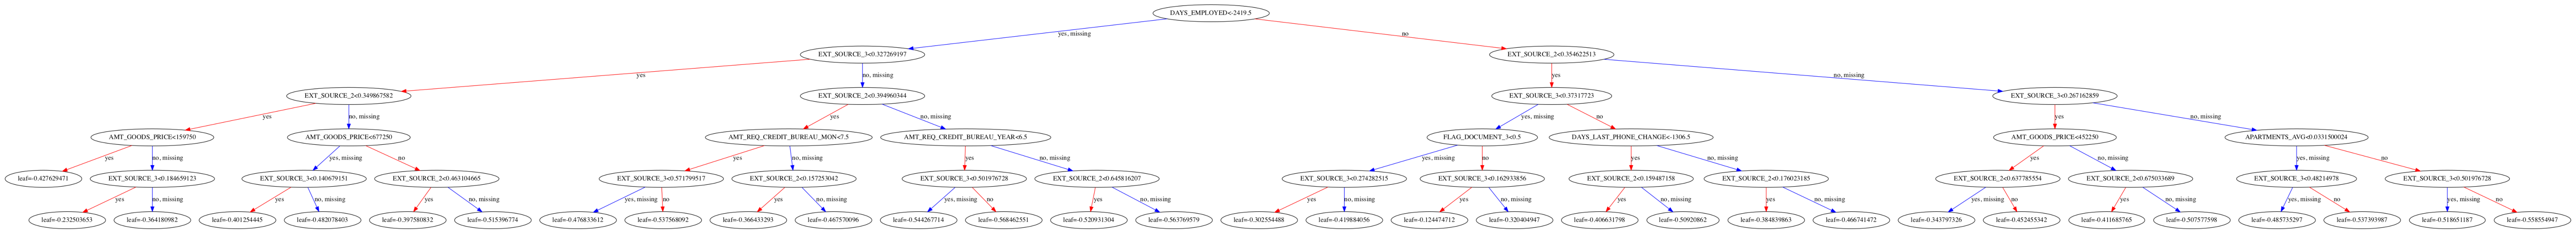

In [109]:
rcParams['figure.figsize'] = 100,100
plot_tree(xg_reg)

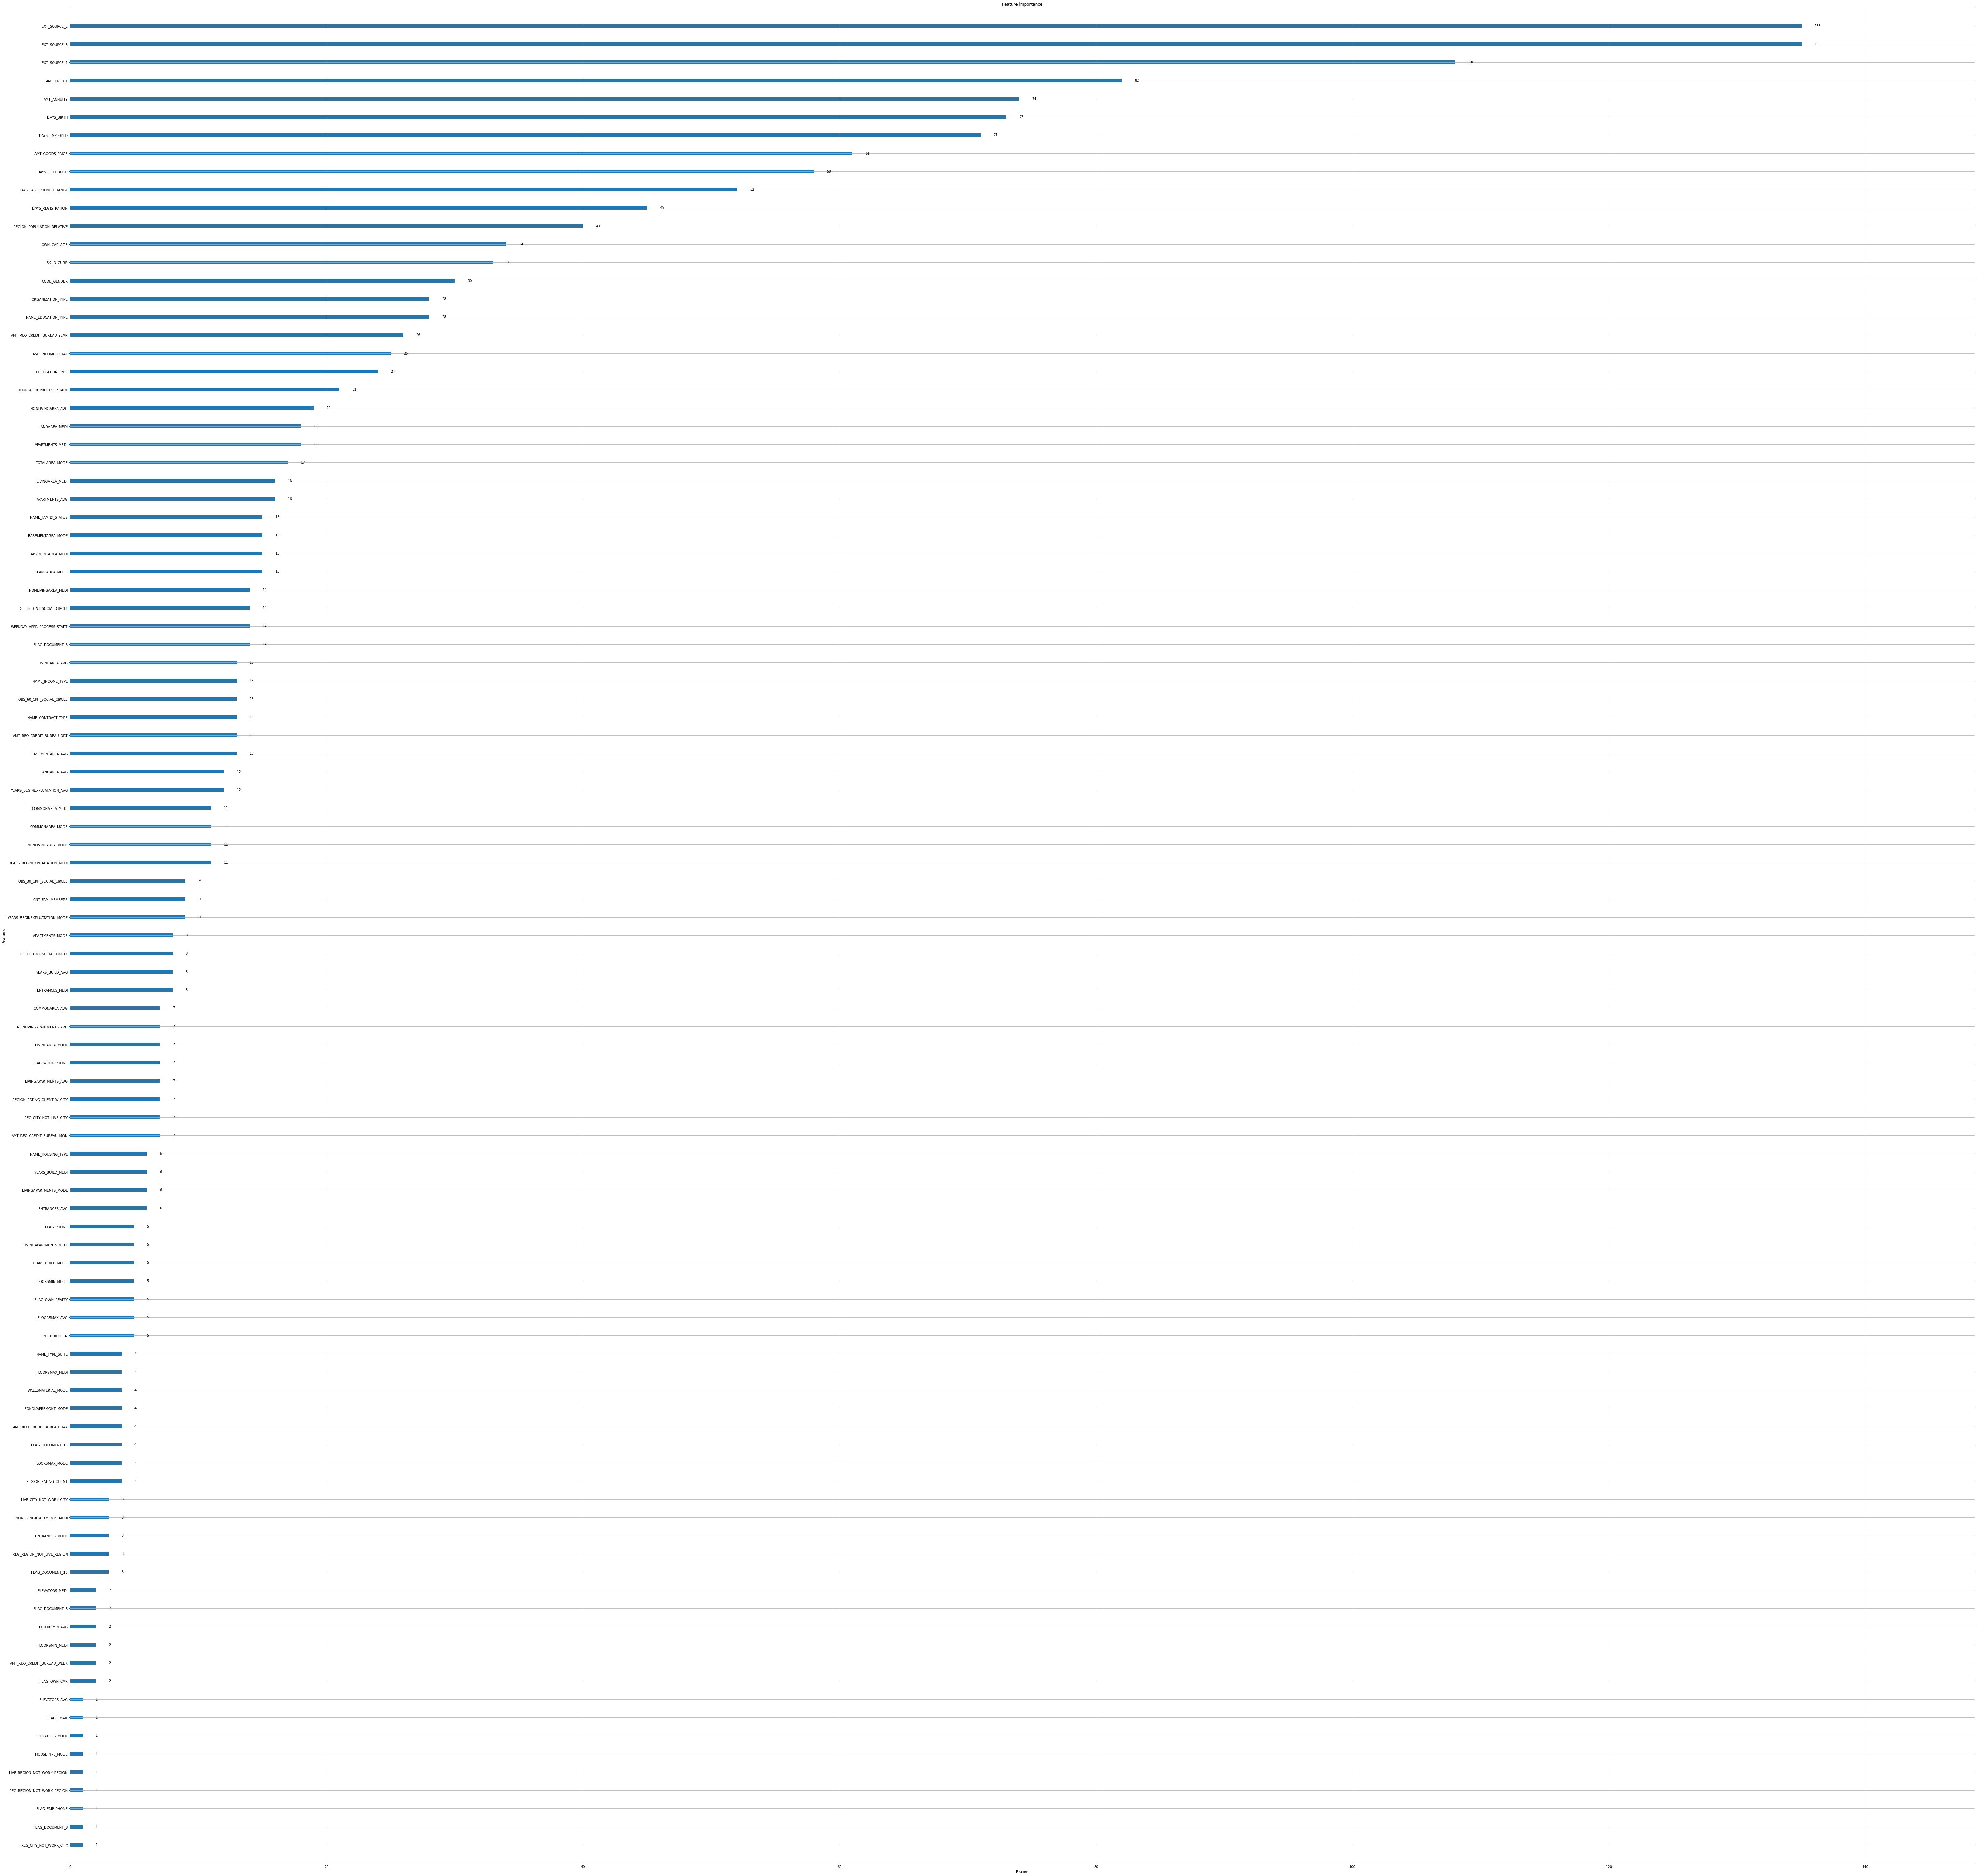

In [113]:
plot_importance(xg_reg)
plt.show()

In [121]:
best_params_dict = xg_reg.get_booster().get_score(importance_type="gain")
best_params_dict_sorted = {k:v for k, v in sorted(best_params_dict.items(), key=lambda x: x[1], reverse=True)}
with open("feature_importance.json", "w+") as f:
    json.dump(best_params_dict_sorted, f)